# Import Library

In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pickle


# Define Global Variables

In [2]:
NUM_WORDS = 30000
EMBEDDING_DIM = 16
MAXLEN = 100
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAIN_FILE = "./dataset/processed_train.csv"
TEST_FILE = "./dataset/processed_test.csv"
STOPWORDS_FILE = "./dataset/stopwordbahasa.csv"
STOPWORDS = []

In [3]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

In [4]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/external/
  inflating: dataset/external/emoticon.txt  
  inflating: dataset/external/slangword.csv  
  inflating: dataset/processed_test.csv  
  inflating: dataset/processed_train.csv  
   creating: dataset/raw/
  inflating: dataset/raw/test.csv    
  inflating: dataset/raw/train.csv   
  inflating: dataset/stopwordbahasa.csv  


# Define Remove Stopwords

In [5]:
def load_stopwords(stopwords_file=STOPWORDS_FILE):
    """
    Loads the stopwords from the stopwords file

    Args:
        stopwords_file (string): path to the stopwords file
    Returns:
        stopwords (list): list of stopwords
    """
    with open(stopwords_file, 'r') as f:
        stopwords = []
        reader = csv.reader(f)
        for row in reader:
            stopwords.append(row[0])

        return stopwords

STOPWORDS = load_stopwords(STOPWORDS_FILE)

In [6]:
STOPWORDS[:5]

['ada', 'adalah', 'adanya', 'adapun', 'agak']

In [7]:
def remove_stopwords(sentence, stopwords=STOPWORDS):
    """
    Removes a list of stopwords

    Args:
        sentence (string): sentence to remove the stopwords from
        stopwords (list): list of stopwords to remove from the sentence

    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

# Load Train and Test Data

In [8]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r', encoding="utf8") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            toxicity = int(row[2]) + int(row[3]) + int(row[4]) + int(row[5])
            if toxicity > 0:
                labels.append(1)
            else:
                labels.append(0)
            sentence = row[6]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, np.array(labels)

In [9]:
train_sentences, train_labels = parse_data_from_file(TRAIN_FILE)
test_sentences, test_labels = parse_data_from_file(TEST_FILE)

In [10]:
print(train_sentences[0])
print(train_labels[0])

print(test_sentences[0])
print(test_labels[0])

# number of sentences in the training set
print(f"No. of sentences in the training set: {len(train_sentences)}")

# number of sentences in the test set
print(f"No. of sentences in the test set: {len(test_sentences)}")

# shape of the labels in the training set
print(f"Shape of the labels in the training set: {train_labels.shape}")

# shape of the labels in the test set
print(f"Shape of the labels in the test set: {test_labels.shape}")


jabar provinsi barokah nwoi anjing bodoh npropinsi ngerusak ngebakar gereja jatim provinsi lumbung nasbung jatim npropinsi penghasil gembong teroris jateng lumbung nasbung jateng ngarang stereotip piliah pilih nbangsat pecun
1
spanduk prof video orasi buku lainlain sngat heran rkyat tolol jls niat hizbut tahrir tegakan khilafah ganti negara kesatuan republik indonesia berkilah tegakan khilafah munafik apanya khilafah
1
No. of sentences in the training set: 6995
No. of sentences in the test set: 778
Shape of the labels in the training set: (6995,)
Shape of the labels in the test set: (778,)


# Tokenization - Sequences and Padding

In [11]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences

    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """

    ### START CODE HERE

    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)

    ### END CODE HERE

    return tokenizer

In [12]:
# Test function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 28899 words

<OOV> token included in vocabulary


In [13]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length

    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence

    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """

    ### START CODE HERE

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)

    ### END CODE HERE

    return padded_sequences

In [14]:
# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
test_padded_seq = seq_and_pad(test_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {test_padded_seq.shape}")

Padded training sequences have shape: (6995, 100)

Padded validation sequences have shape: (778, 100)


# Create Model

In [85]:
# model
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    tf.random.set_seed(123)

    ### START CODE HERE

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002),
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

    ### END CODE HERE

    return model

In [ ]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
history = model.fit(train_padded_seq, train_labels, epochs=50, validation_data=(test_padded_seq, test_labels))

Epoch 1/50
219/219 [==============================] - 4s 11ms/step - loss: 0.6907 - accuracy: 0.5600 - precision: 0.5611 - recall: 0.9944 - val_loss: 0.6910 - val_accuracy: 0.5553 - val_precision: 0.5553 - val_recall: 1.0000
Epoch 2/50
219/219 [==============================] - 3s 14ms/step - loss: 0.6896 - accuracy: 0.5620 - precision: 0.5619 - recall: 0.9997 - val_loss: 0.6901 - val_accuracy: 0.5553 - val_precision: 0.5553 - val_recall: 1.0000
Epoch 3/50
219/219 [==============================] - 2s 11ms/step - loss: 0.6882 - accuracy: 0.5617 - precision: 0.5617 - recall: 1.0000 - val_loss: 0.6893 - val_accuracy: 0.5553 - val_precision: 0.5553 - val_recall: 1.0000
Epoch 4/50
219/219 [==============================] - 2s 10ms/step - loss: 0.6870 - accuracy: 0.5617 - precision: 0.5617 - recall: 1.0000 - val_loss: 0.6883 - val_accuracy: 0.5553 - val_precision: 0.5553 - val_recall: 1.0000
Epoch 5/50
219/219 [==============================] - 2s 10ms/step - loss: 0.6861 - accuracy: 0.5617

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           480000    
                                                                 
 conv1d (Conv1D)             (None, 98, 16)            784       
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 12)                204       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                        

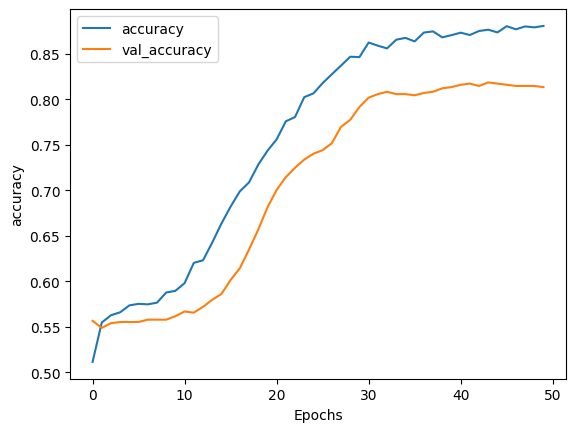

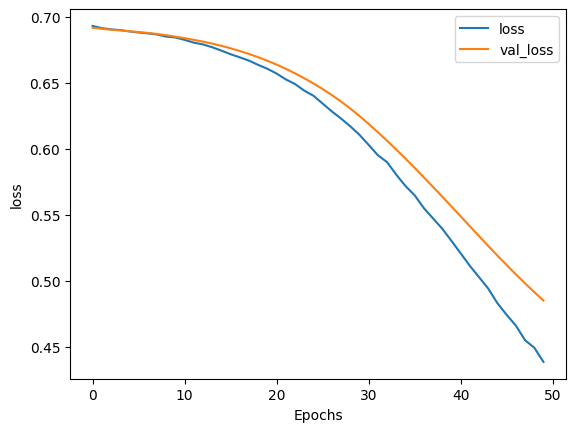

In [17]:
model.summary()
plot_graphs(history, "loss")
plot_graphs(history, "accuracy")
plot_graphs(history, "precision")
plot_graphs(history, "recall")

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 16)           480000    
                                                                 
 conv1d_17 (Conv1D)          (None, 98, 16)            784       
                                                                 
 global_max_pooling1d_17 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_34 (Dense)            (None, 10)                170       
                                                                 
 dense_35 (Dense)            (None, 1)                 11        
                                                     

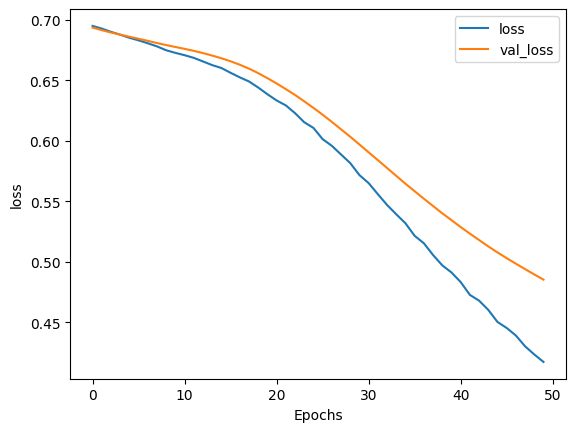

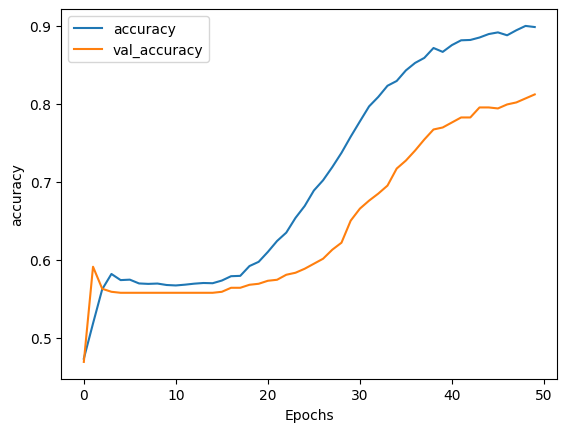

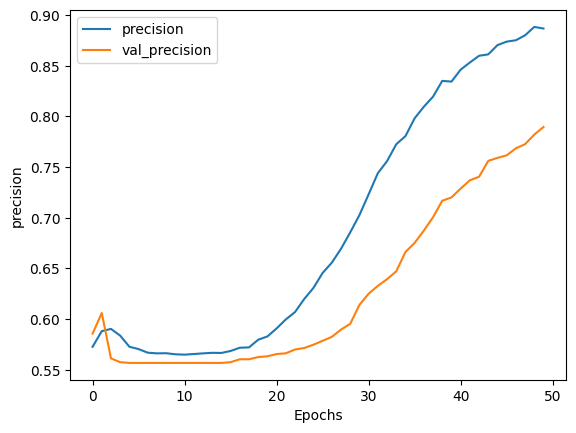

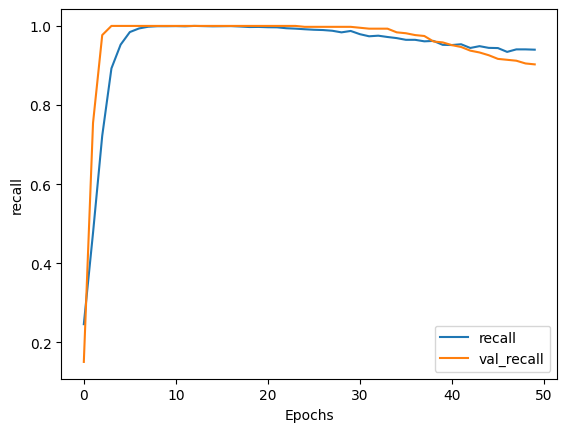

In [66]:
model.summary()
plot_graphs(history, "loss")
plot_graphs(history, "accuracy")
plot_graphs(history, "precision")
plot_graphs(history, "recall")

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 16)           480000    
                                                                 
 conv1d_17 (Conv1D)          (None, 98, 16)            784       
                                                                 
 global_max_pooling1d_17 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_34 (Dense)            (None, 10)                170       
                                                                 
 dense_35 (Dense)            (None, 1)                 11        
                                                     

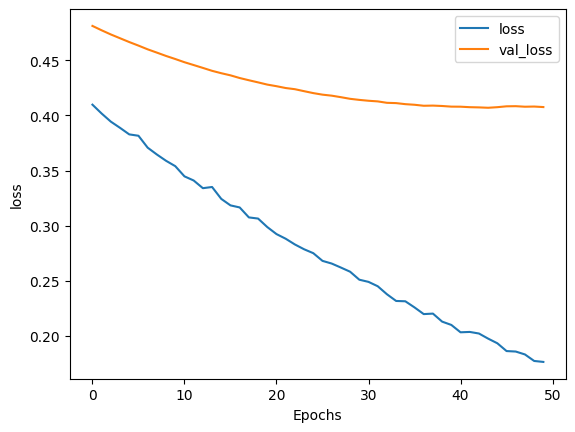

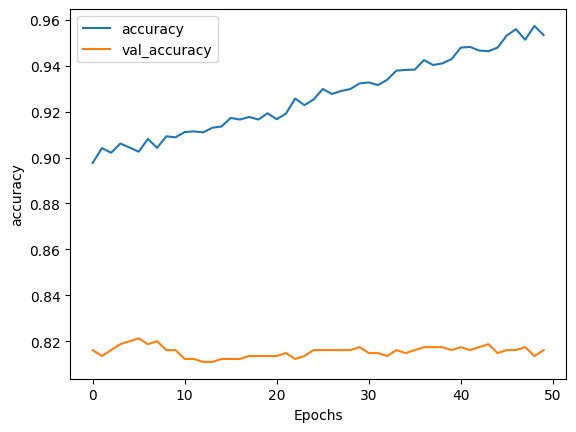

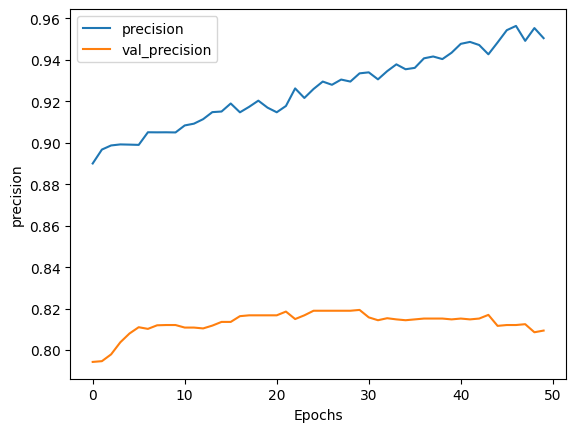

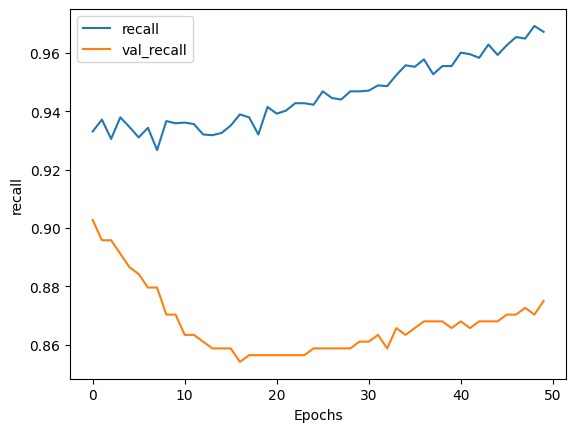

In [68]:
model.summary()
plot_graphs(history, "loss")
plot_graphs(history, "accuracy")
plot_graphs(history, "precision")
plot_graphs(history, "recall")

In [78]:
# model_2
def create_model_2(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    tf.random.set_seed(123)

    ### START CODE HERE

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation="relu"),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

    ### END CODE HERE

    return model

In [79]:
model_2 = create_model_2(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
history_2 = model_2.fit(train_padded_seq, train_labels, epochs=10, validation_data=(test_padded_seq, test_labels))




Epoch 1/10
219/219 [==============================] - 6s 20ms/step - loss: 0.5676 - accuracy: 0.6816 - precision: 0.6559 - recall: 0.9114 - val_loss: 0.4283 - val_accuracy: 0.7918 - val_precision: 0.8835 - val_recall: 0.7199
Epoch 2/10
219/219 [==============================] - 4s 17ms/step - loss: 0.3005 - accuracy: 0.8766 - precision: 0.8860 - recall: 0.8956 - val_loss: 0.4151 - val_accuracy: 0.8021 - val_precision: 0.8131 - val_recall: 0.8356
Epoch 3/10
219/219 [==============================] - 6s 26ms/step - loss: 0.1400 - accuracy: 0.9560 - precision: 0.9548 - recall: 0.9674 - val_loss: 0.5270 - val_accuracy: 0.7699 - val_precision: 0.7921 - val_recall: 0.7940
Epoch 4/10
219/219 [==============================] - 5s 22ms/step - loss: 0.0571 - accuracy: 0.9840 - precision: 0.9850 - recall: 0.9865 - val_loss: 0.6629 - val_accuracy: 0.7558 - val_precision: 0.7801 - val_recall: 0.7801
Epoch 5/10
219/219 [==============================] - 4s 18ms/step - loss: 0.0279 - accuracy: 0.9933

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 100, 16)           480000    
                                                                 
 conv1d_21 (Conv1D)          (None, 94, 128)           14464     
                                                                 
 global_max_pooling1d_21 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 16)                2064      
                                                                 
 dense_43 (Dense)            (None, 1)                 17        
                                                     

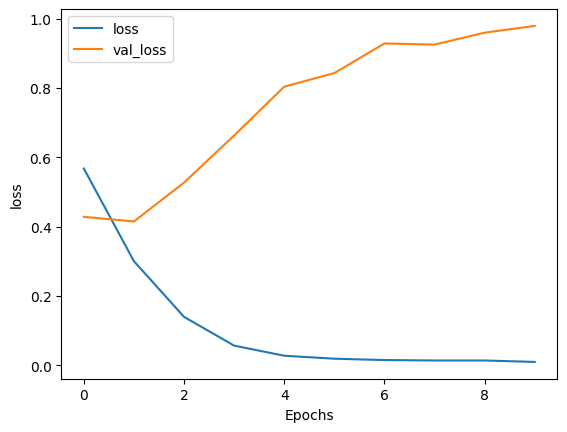

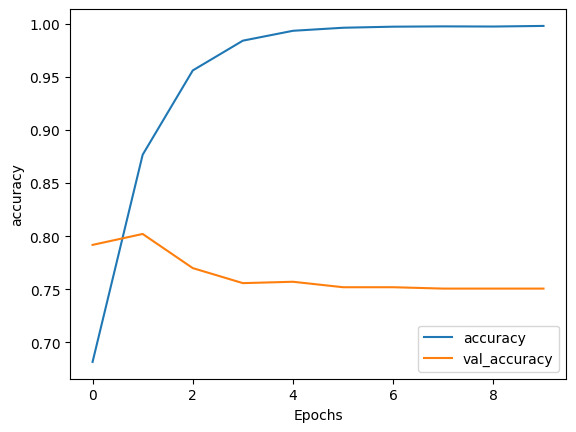

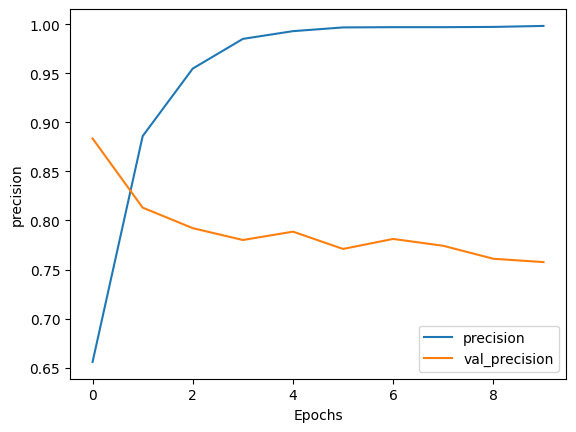

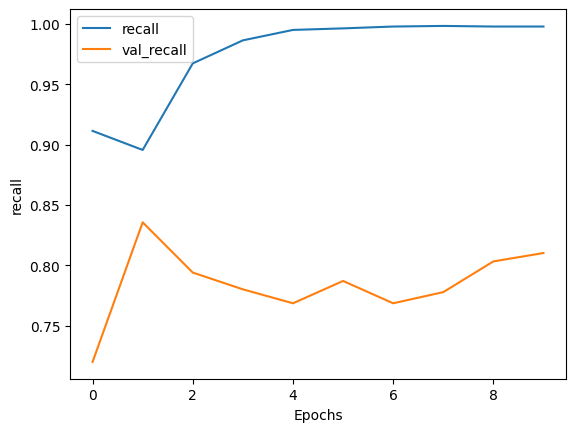

In [80]:
model_2.summary()
plot_graphs(history_2, "loss")
plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "precision")
plot_graphs(history_2, "recall")


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 16)           480000    
                                                                 
 conv1d_6 (Conv1D)           (None, 98, 3)             147       
                                                                 
 global_max_pooling1d_6 (Glo  (None, 3)                0         
 balMaxPooling1D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 3)                 0         
                                                                 
 dense_12 (Dense)            (None, 3)                 12        
                                                                 
 dense_13 (Dense)            (None, 1)                 4         
                                                      

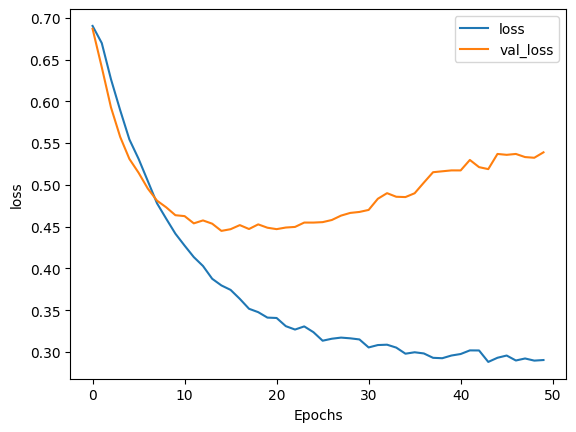

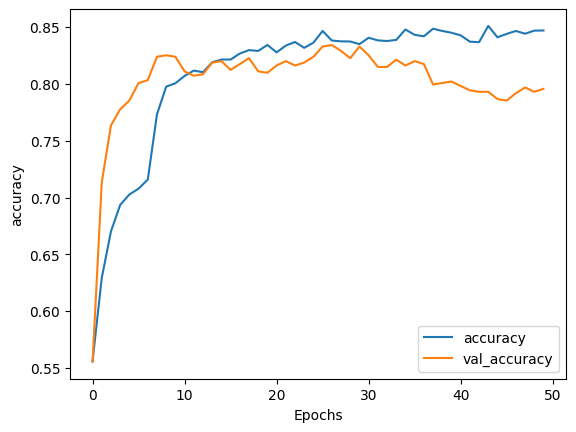

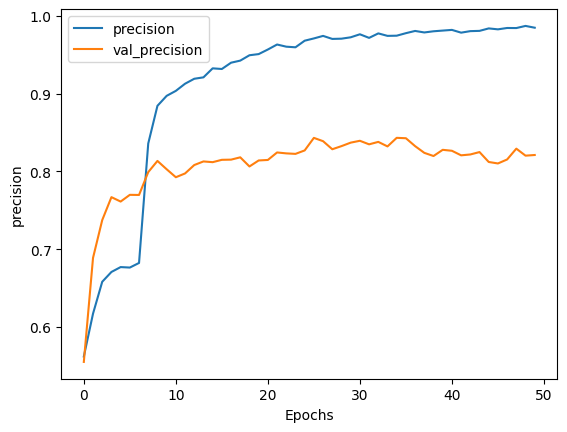

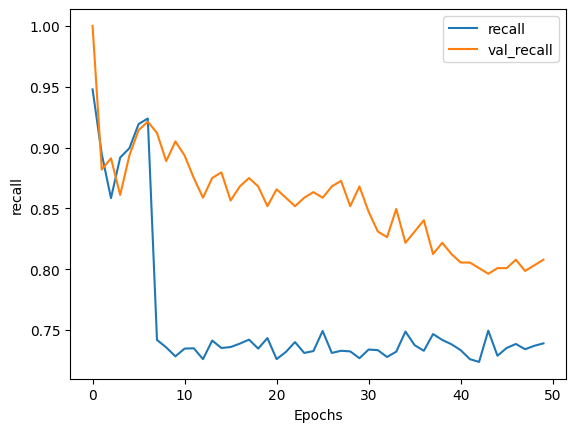

In [35]:
model_2.summary()
plot_graphs(history_2, "loss")
plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "precision")
plot_graphs(history_2, "recall")

In [ ]:
# model_3
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    tf.random.set_seed(123)

    ### START CODE HERE

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [ ]:
model_3 = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history_3 = model_3.fit(train_padded_seq, train_labels, epochs=100, validation_data=(test_padded_seq, test_labels))

In [ ]:
# model_4
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    tf.random.set_seed(123)

    ### START CODE HERE

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation="relu"),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [ ]:
model_4 = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

model_4.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 16)           480000    
                                                                 
 conv1d_16 (Conv1D)          (None, 94, 128)           14464     
                                                                 
 bidirectional_28 (Bidirecti  (None, 100)              71600     
 onal)                                                           
                                                                 
 dense_30 (Dense)            (None, 100)               10100     
                                                                 
 dense_31 (Dense)            (None, 1)                 101       
                                                                 
Total params: 576,265
Trainable params: 576,265
Non-trainable params: 0
_______________________________________________

In [ ]:
history_4 = model_4.fit(train_padded_seq, train_labels, epochs=100, validation_data=(test_padded_seq, test_labels))

Epoch 1/100
14/14 [==============================] - 9s 257ms/step - loss: 0.6935 - accuracy: 0.5036 - val_loss: 0.6872 - val_accuracy: 0.5553
Epoch 2/100
14/14 [==============================] - 3s 188ms/step - loss: 0.6811 - accuracy: 0.5606 - val_loss: 0.6780 - val_accuracy: 0.5553
Epoch 3/100
14/14 [==============================] - 4s 297ms/step - loss: 0.5705 - accuracy: 0.6983 - val_loss: 0.7751 - val_accuracy: 0.6054
Epoch 4/100
14/14 [==============================] - 2s 169ms/step - loss: 0.2266 - accuracy: 0.9335 - val_loss: 0.8805 - val_accuracy: 0.6967
Epoch 5/100
14/14 [==============================] - 2s 169ms/step - loss: 0.0243 - accuracy: 0.9929 - val_loss: 0.8832 - val_accuracy: 0.7095
Epoch 6/100
14/14 [==============================] - 3s 183ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1576 - val_accuracy: 0.7134
Epoch 7/100
14/14 [==============================] - 2s 121ms/step - loss: 5.7200e-04 - accuracy: 1.0000 - val_loss: 1.3448 - val_accuracy: 0.

# Evaluate The Model

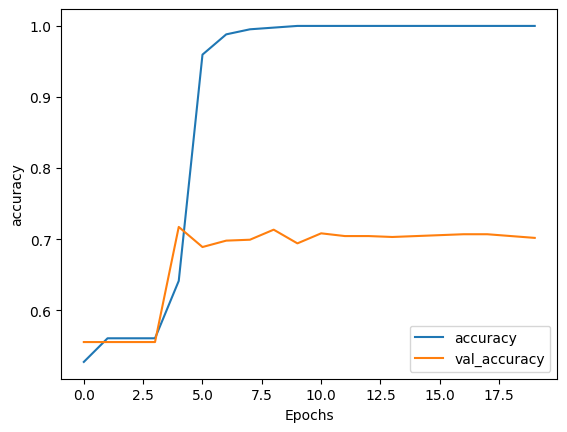

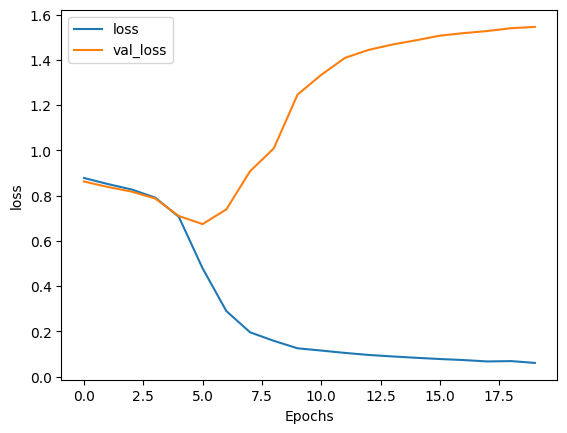

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

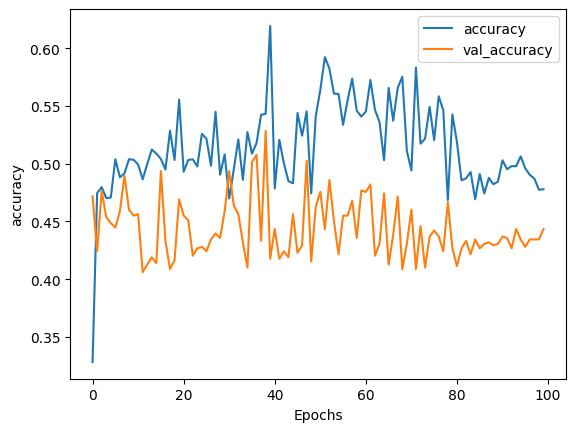

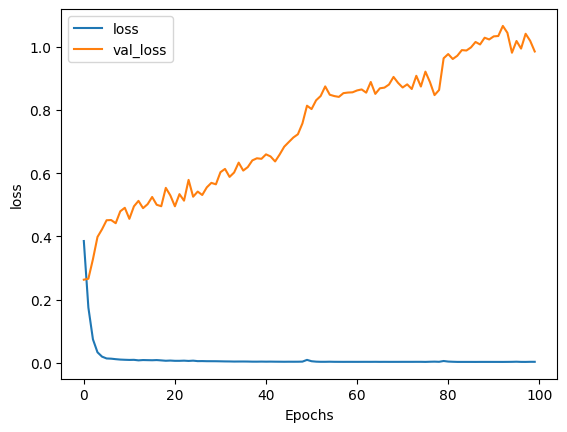

In [ ]:
def plot_graphs(history_2, metric):
    plt.plot(history_2.history[metric])
    plt.plot(history_2.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "loss")

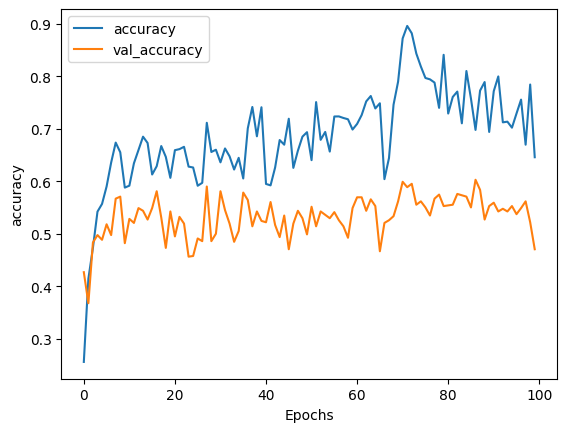

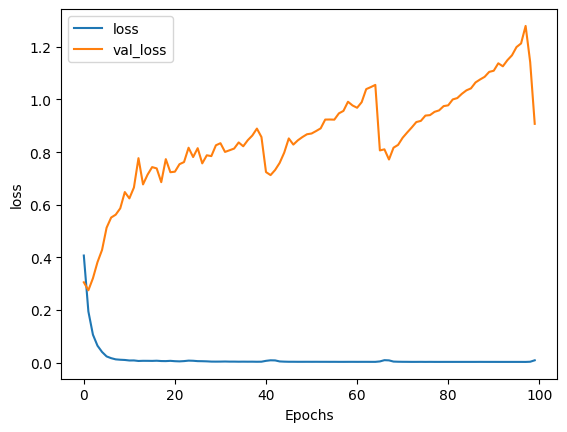

In [ ]:
def plot_graphs(history_3, metric):
    plt.plot(history_3.history[metric])
    plt.plot(history_3.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history_3, "accuracy")
plot_graphs(history_3, "loss")

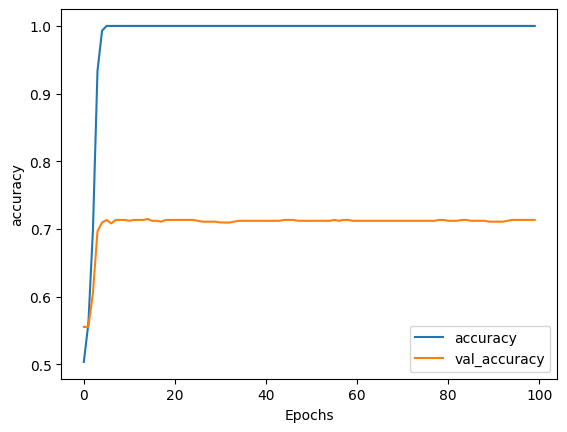

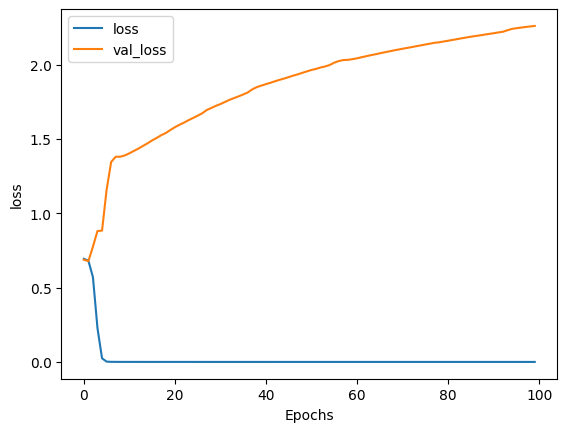

In [ ]:
def plot_graphs(history_4, metric):
    plt.plot(history_4.history[metric])
    plt.plot(history_4.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history_4, "accuracy")
plot_graphs(history_4, "loss")

# Save The Model

In [81]:
model.save('toxic_comment_model_var_2.h5')

# Make Prediction

In [82]:

#model.predict(test_padded_seq) > 0.9 # 0.5 is the threshold


[[ 1697  2976   126 ...     0     0     0]
 [18241    97  2084 ...     0     0     0]
 [   37  1284  2451 ...     0     0     0]
 ...
 [    1   227   356 ...     0     0     0]
 [   83  9167  3662 ...     0     0     0]
 [ 6955     4   862 ...     0     0     0]]


# Load Model

In [83]:
model = tf.keras.models.load_model('toxic_comment_model_var_2.h5')

# Save to Saved Model Format

In [84]:

# save to saved model format
tf.saved_model.save(model, "models/toxic_comment_model_var_1_savedmodel")

# Save Tokenizer

In [ ]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
!zip -r /content/Archive.zip /content/ToZip/

  adding: content/ToZip/ (stored 0%)
  adding: content/ToZip/tokenizer.pickle (deflated 55%)
  adding: content/ToZip/models/ (stored 0%)
  adding: content/ToZip/models/toxic_comment_model_var_1_savedmodel/ (stored 0%)
  adding: content/ToZip/models/toxic_comment_model_var_1_savedmodel/variables/ (stored 0%)
  adding: content/ToZip/models/toxic_comment_model_var_1_savedmodel/variables/variables.data-00000-of-00001 (deflated 21%)
  adding: content/ToZip/models/toxic_comment_model_var_1_savedmodel/variables/variables.index (deflated 61%)
  adding: content/ToZip/models/toxic_comment_model_var_1_savedmodel/assets/ (stored 0%)
  adding: content/ToZip/models/toxic_comment_model_var_1_savedmodel/fingerprint.pb (stored 0%)
  adding: content/ToZip/models/toxic_comment_model_var_1_savedmodel/saved_model.pb (deflated 88%)
  adding: content/ToZip/toxic_comment_model_var_2.h5 (deflated 21%)
  adding: content/ToZip/dataset/ (stored 0%)
  adding: content/ToZip/dataset/stopwordbahasa.csv (deflated 67%)